In [1]:
import numpy as np
import numpy.random as npr
import yfinance as yf
from blackscholes import BlackScholesCall
import matplotlib.pyplot as plt

In [2]:
def normalpoissonprocess(lambda_, T,delta,m,trials):
    t = np.zeros(trials)
    jumps = np.zeros(trials)
    while any(t < T):
        t = t + npr.exponential(1 / lambda_,size=trials)
        jumps = jumps + npr.normal(m, delta,size=trials)*(t<T)
        return jumps

def jumpdiffusion(s0, vol, r, T, increment, trials,lambda_,delta,m):
    S = np.zeros((increment, trials)) 
    S[0] = s0
    dt = T/increment
    k = np.exp(m + .5 *delta**2) - 1
    for i in range(1, increment): 
        jumps = normalpoissonprocess(lambda_,dt,delta,m,trials)
        dW = np.sqrt(dt) * npr.standard_normal(size=trials)
        S[i] = S[i-1] * np.exp((r - 0.5*vol**2 - lambda_*k)*dt + vol*dW + jumps)
    return S

def geometricbrownian(s0,vol,r,T,increment,trails):
    S = np.zeros((increment,trails))
    S[0]=s0
    dt = T/increment
    for i in range(1,increment):
        S[i]=S[i-1] * np.exp((r-0.5*vol**2)*dt + vol*np.sqrt(dt)*npr.standard_normal(size=trails))
    return S

def optionPricer(flag, strike, S, r, T,barrier=None):
    if flag == 'call':
        Payoff = np.maximum(S[-1]-strike,0)
    elif flag == 'call knock-in':
        temp = (S>=barrier)
        sum = np.zeros(len(S[0]))
        for i in range(0,len(S)):
            sum += temp[i]
        Payoff = (sum>0)*np.maximum(S[-1]-strike,0)
    elif flag == 'put':
        Payoff = np.maximum(strike-S[-1],0)
    Payoff = np.exp(-r*T) * Payoff.mean()
    return Payoff

def mcOptionPrice(flag, s0, strike, r, vol, T, increment, trials,barrier=None):
    return optionPricer(flag, strike, geometricbrownian(s0, vol, r, T, increment, trials), r, T,barrier)



In [3]:
saab = yf.download('SAAB-B.ST', period='1y')
investor = yf.download('INVE-B.ST', period='1y')
hexatronic = yf.download('HTRO.ST', period='1y')

saab = saab['Close']
investor = investor['Close']
hexatronic = hexatronic['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
interdayreturn = [saab.iloc[i+1] / saab.iloc[i] - 1 for i in range(len(saab) - 1)]
vol_saab = np.std(interdayreturn) * np.sqrt(252)
print("Volatility Saab:", vol_saab)

interdayreturn = [investor.iloc[i+1] / investor.iloc[i] - 1 for i in range(len(investor) - 1)]
vol_investor = np.std(interdayreturn) * np.sqrt(252)
print("Volatility Investor:", vol_investor)

interdayreturn= [hexatronic.iloc[i+1] / hexatronic.iloc[i] - 1 for i in range(len(hexatronic) - 1)]
vol_hexatronic = np.std(interdayreturn) * np.sqrt(252)
print("Volatility Hexatronic:", vol_hexatronic)

Volatility Saab: 0.3910240402081561
Volatility Investor: 0.1605180568158158
Volatility Hexatronic: 0.6240956652182387


C:\Users\William\AppData\Local\Temp\ipykernel_23080\2941178505.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  optionprice = mcOptionPrice('call',saab[-1],180,r,vol_saab,T,1000,5000)
C:\Users\William\AppData\Local\Temp\ipykernel_23080\2941178505.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  knockinprice = mcOptionPrice('call knock-in',saab[-1],180,r,vol_saab,T,1000,5000,300)


Call option price for SAAB: 55.097718162257564
Knock-in call option price for SAAB: 46.1456288170312


C:\Users\William\AppData\Local\Temp\ipykernel_23080\2941178505.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  W = geometricbrownian(saab[-1],vol_saab,r,T,1000,1)
C:\Users\William\AppData\Local\Temp\ipykernel_23080\2941178505.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  D = jumpdiffusion(saab[-1],vol_saab,r,T,1000,1,0.1,0.9,0.1)


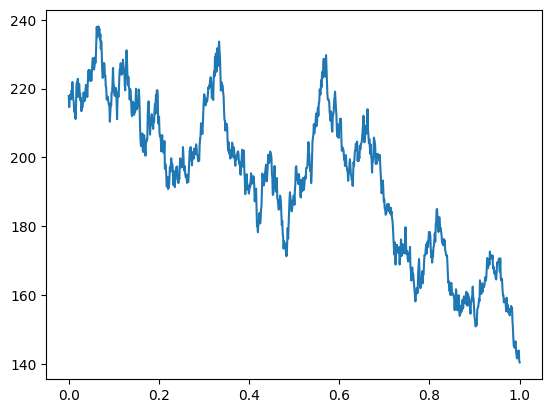

In [6]:
T = 1 # Year to maturity
r = 0.0229 # Risk free rate
# Option price for SAAB
optionprice = mcOptionPrice('call',saab[-1],180,r,vol_saab,T,1000,5000)
print("Call option price for SAAB:",optionprice)
knockinprice = mcOptionPrice('call knock-in',saab[-1],180,r,vol_saab,T,1000,5000,300)
print("Knock-in call option price for SAAB:",knockinprice)
W = geometricbrownian(saab[-1],vol_saab,r,T,1000,1)
D = jumpdiffusion(saab[-1],vol_saab,r,T,1000,1,0.1,0.9,0.1)
plt.plot(np.linspace(0,T,1000),D)